# Imports

In [1]:
import datetime
import sklearn.model_selection
import spacy
import requests
import os
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import itertools
import seaborn as sns
import lightgbm
import tsfresh
from sklearn.preprocessing import MinMaxScaler

# Helper Methods

In [2]:
DATA_PATH = "../Data/"
DATA_PATH_NEW = "../Data/Data_new/"
df_article_codes = pd.read_csv("article_codes.csv")

In [3]:
def get_fileNames(category: str, path):
    file_names = []
    for files in os.listdir(path + category):
        if files.endswith(".csv"):
            files = files[0:len(files)-4]
            file_names.append(files)
    return file_names

In [125]:
def smape(target, forecast):
    if type(target) == pd.core.frame.DataFrame:
        target = target.values

    denominator = np.abs(target) + np.abs(forecast)
    flag = denominator == 0.

    smape = 2 * np.mean(
        (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
    )
    return smape

In [7]:
def make_data_new(category, article, days_to_predict):
    df = pd.read_csv(f"{DATA_PATH_NEW}{category}/{article}.csv")
    df.index = df["timestamp"]
    df.drop(['timestamp'], axis=1, inplace=True)
    df.index = pd.to_datetime(df.index, format="%Y%m%d%H")

    #dfN = df[["views"]].copy()
    #df["target"] = df.views.shift(-1)

    # normalization
    scaler = MinMaxScaler(feature_range=(1, 5))
    data = np.array(df["views"])
    data = data.reshape(len(data), 1)
    scaler = scaler.fit(data)
    data = scaler.transform(data)
    df["views"] = data

    df.dropna(inplace=True)
    df = create_features(df)

    #df = df.loc[(df.index >= '2015.01.01') & (df.index <= "2021.01.01")]
    dfNeu = df.tail(days_to_predict)
    df = df.head(len(df) - days_to_predict)

    return df, dfNeu

def make_data(category, article, days_to_predict):
    df = pd.read_csv(f"{DATA_PATH}{category}/{article}.csv")
    code = df_article_codes.loc[df_article_codes["article"] == df["article"][0].replace("_", " ")]["code"]
    df = df.drop(["project", "granularity", "access", "agent", "article"], axis=1)
    df["article"] = list(code)[0]

    df.index = df["timestamp"]
    df.index = pd.to_datetime(df.index)
    df.drop(['timestamp'], axis=1, inplace=True)

    # normalization
    scaler = MinMaxScaler(feature_range=(1, 5))
    data = np.array(df["views"])
    data = data.reshape(len(data), 1)
    scaler = scaler.fit(data)
    data = scaler.transform(data)
    df["views"] = data

    df.dropna(inplace=True)
    df = create_features(df)

    #df = df.loc[(df.index >= '2015.01.01') & (df.index <= "2021.01.01")]
    dfNeu = df.tail(days_to_predict)
    df = df.head(len(df) - days_to_predict)

    return df, dfNeu
make_data("Games", "Advance Wars", 14)[0]

,views,article,dayofweek,month,quarter,dayofyear,year,avg,t-1
timestamp,,,,,,,,,
2015-07-01,1.086553,0,2,7,3,182,2015,1.086553,NaN
2015-07-02,1.102897,0,3,7,3,183,2015,1.094725,1.086553
2015-07-03,1.089896,0,4,7,3,184,2015,1.093115,1.102897
2015-07-04,1.065750,0,5,7,3,185,2015,1.086274,1.089896
2015-07-05,1.061664,0,6,7,3,186,2015,1.081352,1.065750
...,...,...,...,...,...,...,...,...,...
2021-12-14,1.027117,0,1,12,4,348,2021,1.072257,1.019688
2021-12-15,1.046434,0,2,12,4,349,2021,1.072247,1.027117
2021-12-16,1.026374,0,3,12,4,350,2021,1.072227,1.046434


In [47]:
counter = 0
files = []
code = []
for category in ["Games", "Music", "Movies", "Literary"]:
    for file in get_fileNames(category, DATA_PATH):
        files.append(file)
        code.append(counter)
        counter += 1
df = pd.DataFrame({"article": files, "code": code})
df.to_csv("article_codes.csv")

# Features

In [103]:
def create_features(df):
    if isinstance(df, tuple):
        df = df[0]
    df = df.copy()
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["dayofyear"] = df.index.dayofyear
    df["year"] = df.index.year
    avg = []
    for i in range(1, len(df["views"]) + 1):
        avg.append(df["views"][0:i].mean())
    df["avg"] = avg
    for i in range(1, 8):
        df[f"t-{i}"] = df["views"].shift(i).ffill()

    return df

# Preprocess Data

In [107]:
CATEGORIES = ["Games", "Movies", "Music", "Literary"]

for category in CATEGORIES:
    pd.concat(make_data(category, file, 14)[0] for file in get_fileNames(category, DATA_PATH)).to_csv(f"data_{category}_small.csv")

# XGBoost

In [102]:
FEATURES = ["dayofweek", "month", "quarter", "dayofyear", "year", "avg", "t-1", "t-2", "t-3", "t-4", "t-5", "t-6", "t-7", "article"] #views det letzten tage
TARGET = "views"
xgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6)

In [109]:
%%time

def train_xg(categories, model):
    df_all = pd.concat([pd.read_csv(f"data_{category}_small.csv") for category in categories])
    print(len(df_all))
    train_data, test_data = sklearn.model_selection.train_test_split(df_all, test_size=0.3, random_state=69)

    X_train = train_data[FEATURES]
    y_train = train_data[TARGET]
    X_test = test_data[FEATURES]
    y_test = test_data[TARGET]

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=1000)

param = {
    'early_stopping_rounds': 50,
    'disable_default_eval_metric': True,
    'eval_metric': smape,
    'lambda': 0.0011256534045695,
    'alpha': 0.0017171511650539144,
    'colsample_bytree': 1.0,
    'subsample': 0.4,
    'learning_rate': 0.018,
    'max_depth': 13,
    'random_state': 2020,
    'min_child_weight': 6,
    'n_estimators': 10000,
    'tree_method': 'gpu_hist'
}

xgmodel = xgb.XGBRegressor(**param)
train_xg(["Games", "Music", "Movies", "Literary"], xgmodel)

711609
[0]	validation_0-smape:0.81722	validation_1-smape:0.81676
[297]	validation_0-smape:0.03527	validation_1-smape:0.03959
CPU times: total: 24.8 s
Wall time: 19.7 s


In [77]:
xgmodel.save_model("xgboost_small")

C:\Users\Tobias\anaconda3\envs\prediction\lib\site-packages\xgboost\sklearn.py:787: UserWarning: eval_metric is not saved in Scikit-Learn meta.
  warnings.warn(


In [120]:
def eval_xg(xgmodel):
    smapes = []
    for category in CATEGORIES:
        for file in get_fileNames(category, DATA_PATH):
            predictions = []
            old, df = make_data(category, file, 14)
            indeces = df.index
            df["t-1"][1:] = None
            df["avg"][1:] = None
            avgs = [df["avg"][indeces[0]]] * len(old)
            for i in range(0, 13):
                tmp = pd.DataFrame(df[FEATURES].loc[indeces[i]]).T
                pred = xgmodel.predict(tmp)[0]
                predictions.append(pred)
                avgs.append(pred)

                df.loc[indeces[i + 1], 'avg'] = (sum(avgs) / len(avgs))
                for j in range(1, 8):
                    if i + j < len(indeces):
                        df.loc[indeces[i + j], f't-{j}'] = pred
            tmp = pd.DataFrame(df[FEATURES].loc[indeces[13]]).T
            pred = xgmodel.predict(tmp)[0]
            predictions.append(pred)
            df["predictions"] = predictions

            smapes.append(smape(df["views"], df["predictions"]))
    return smapes

In [51]:
import optuna

category = ["Music", "Games", "Literary", "Movies"]
data = []
for i in category:
    for file in get_fileNames(i):
        df, df_new_data = make_data(i, file, 14)
        data.append(df)
data = pd.concat(data)

def objective(trial,data=data):

    train, test = sklearn.model_selection.train_test_split(data, test_size=0.3,random_state=42)

    train_x = train[FEATURES]
    train_y = train[TARGET]

    test_x = test[FEATURES]
    test_y = test[TARGET]

    param = {
        'eval_metric': smape,
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)

    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=50,verbose=1000)

    preds = model.predict(test_x)

    loss = smape(test_y, preds)

    return loss
'''
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
'''

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: '../Data/Data_new/Music'

In [28]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,0.088959,2022-12-07 10:55:23.210909,2022-12-07 10:55:26.013063,0 days 00:00:02.802154,2.266206,0.4,0.056718,0.020,11,275,2020,0.6,COMPLETE
1,1,0.058613,2022-12-07 10:55:26.015062,2022-12-07 10:55:55.036969,0 days 00:00:29.021907,0.001183,1.0,0.001616,0.010,13,7,2020,0.4,COMPLETE
2,2,0.078957,2022-12-07 10:55:55.037969,2022-12-07 10:55:58.791749,0 days 00:00:03.753780,1.340391,0.7,0.029292,0.014,7,124,2020,1.0,COMPLETE
3,3,0.070615,2022-12-07 10:55:58.793749,2022-12-07 10:56:04.699759,0 days 00:00:05.906010,0.453258,0.8,1.464189,0.012,9,36,2020,0.7,COMPLETE
4,4,0.081403,2022-12-07 10:56:04.701758,2022-12-07 10:56:08.561759,0 days 00:00:03.860001,0.036556,0.9,1.383037,0.010,5,280,2020,0.8,COMPLETE
5,5,0.069526,2022-12-07 10:56:08.563760,2022-12-07 10:56:15.584009,0 days 00:00:07.020249,0.524031,0.9,9.823132,0.020,17,272,2020,0.8,COMPLETE
6,6,0.070584,2022-12-07 10:56:15.586009,2022-12-07 10:56:25.623018,0 days 00:00:10.037009,0.685650,0.8,2.543200,0.008,11,223,2020,0.8,COMPLETE
7,7,0.070736,2022-12-07 10:56:25.625018,2022-12-07 10:56:43.938845,0 days 00:00:18.313827,0.006902,0.7,0.232635,0.008,17,299,2020,1.0,COMPLETE
8,8,0.079056,2022-12-07 10:56:43.939845,2022-12-07 10:56:51.756275,0 days 00:00:07.816430,0.013011,0.6,0.078302,0.010,11,290,2020,0.6,COMPLETE
9,9,0.102615,2022-12-07 10:56:51.758275,2022-12-07 10:56:54.924614,0 days 00:00:03.166339,0.002358,0.3,0.346258,0.014,11,290,2020,0.6,COMPLETE


In [39]:
Best_trial = study.best_trial.params
Best_trial["n_estimators"], Best_trial["tree_method"] = 10000, 'gpu_hist'
Best_trial

{'lambda': 0.0011256534045695,
 'alpha': 0.0017171511650539144,
 'colsample_bytree': 1.0,
 'subsample': 0.4,
 'learning_rate': 0.018,
 'max_depth': 13,
 'random_state': 2020,
 'min_child_weight': 6,
 'n_estimators': 10000,
 'tree_method': 'gpu_hist'}

In [ ]:
Best_trial = study.best_trial.params
Best_trial["n_estimators"], Best_trial["tree_method"] = 10000, 'gpu_hist'
Best_trial

# Light GBM

In [173]:
%%time

param = {'reg_alpha': 0.010714668731023664,
         'reg_lambda': 0.6372414076289301,
         'colsample_bytree': 0.6,
         'subsample': 0.7,
         'learning_rate': 0.017,
         'max_depth': 10,
         'num_leaves': 658,
         'min_child_samples': 11,
         'min_data_per_groups': 39,}

lgbm_model = lightgbm.LGBMRegressor(n_estimators=5000, **param, first_metric_only=True, metric="smape")

def smape2(target, forecast):
    return "smape", smape(np.array(target), np.array(forecast)), False

def train_lgbm(categories, model):
    df_all = pd.concat([pd.read_csv(f"data_{category}_small.csv") for category in categories])
    print(len(df_all))
    train_data, test_data = sklearn.model_selection.train_test_split(df_all, test_size=0.3, random_state=69)

    X_train = train_data[FEATURES]
    y_train = train_data[TARGET]
    X_test = test_data[FEATURES]
    y_test = test_data[TARGET]

    model.fit(X_train, y_train, eval_metric=smape2, eval_set=[(X_test, y_test)],verbose=500 ,early_stopping_rounds=50)
train_lgbm(["Games", "Music", "Movies", "Literary"], lgbm_model)

711609


C:\Users\Tobias\anaconda3\envs\prediction\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tobias\anaconda3\envs\prediction\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's smape: 0.039501
[1000]	valid_0's smape: 0.0393404
CPU times: total: 5min 55s
Wall time: 1min 1s


In [154]:
def eval_lgbm(model):
    smapes = []
    for category in CATEGORIES:
        for file in get_fileNames(category, DATA_PATH):
            predictions = []
            old, df = make_data(category, file, 14)
            indeces = df.index
            df["t-1"][1:] = None
            df["avg"][1:] = None
            avgs = [df["avg"][indeces[0]]] * len(old)
            for i in range(0, 13):
                tmp = pd.DataFrame(df[FEATURES].loc[indeces[i]]).T
                pred = model.predict(tmp)[0]
                predictions.append(pred)
                avgs.append(pred)
                df.loc[indeces[i + 1], 'avg'] = (sum(avgs) / len(avgs))
                for j in range(1, 8):
                    if i + j < len(indeces):
                        df.loc[indeces[i + j], f't-{j}'] = pred
            tmp = pd.DataFrame(df[FEATURES].loc[indeces[13]]).T
            pred = model.predict(tmp)[0]
            predictions.append(pred)
            df["predictions"] = predictions
            smapes.append(smape(df["views"], df["predictions"]))
    return smapes

#smapes = eval_lgbm(lgbm_model)

In [57]:
lgbm_model.booster_.save_model("lgbm_small")

In [ ]:
import optuna

category = ["Music", "Games", "Literary", "Movies"]
data = []
for i in category:
    for file in get_fileNames(i):
        df, df_new_data = make_data(i, file, 14)
        data.append(df)
data = pd.concat(data)

def objective(trial,data=data):

    train, test = sklearn.model_selection.train_test_split(data, test_size=0.3,random_state=42)

    train_x = train[FEATURES]
    train_y = train[TARGET]

    test_x = test[FEATURES]
    test_y = test[TARGET]

    param = {
        'metric': 'mape',
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }

    model = lightgbm.LGBMRegressor(**param)

    model.fit(train_x, train_y, eval_metric="mape", eval_set=[(test_x, test_y)], early_stopping_rounds=50, verbose=1000)

    preds = model.predict(test_x)

    loss = smape(test_y, preds)

    return loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-12-13 15:57:40,360] A new study created in memory with name: no-name-ef6b6112-6d68-4e72-a5a3-a492fc564379
C:\Users\Tobias\AppData\Local\Temp\ipykernel_12404\2576468012.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Tobias\AppData\Local\Temp\ipykernel_12404\2576468012.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\Tobias\anaconda3\envs\prediction\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future r

[1000]	valid_0's mape: 0.074267
[2000]	valid_0's mape: 0.0732938
[3000]	valid_0's mape: 0.0726309
[4000]	valid_0's mape: 0.0721966
[5000]	valid_0's mape: 0.0719433
[6000]	valid_0's mape: 0.0717352


[I 2022-12-13 16:03:56,653] Trial 0 finished with value: 0.0720804641477676 and parameters: {'reg_alpha': 0.3687170089171205, 'reg_lambda': 2.075682721579509, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 193, 'min_child_samples': 208, 'min_data_per_groups': 75}. Best is trial 0 with value: 0.0720804641477676.
C:\Users\Tobias\AppData\Local\Temp\ipykernel_12404\2576468012.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\Tobias\AppData\Local\Temp\ipykernel_12404\2576468012.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inst

[1000]	valid_0's mape: 0.0777921
[2000]	valid_0's mape: 0.0760456
[3000]	valid_0's mape: 0.0751832
[4000]	valid_0's mape: 0.0744117
[5000]	valid_0's mape: 0.0738917
[6000]	valid_0's mape: 0.0734502
[7000]	valid_0's mape: 0.0731962
[8000]	valid_0's mape: 0.0730236
[9000]	valid_0's mape: 0.0727649
[10000]	valid_0's mape: 0.0725985
[11000]	valid_0's mape: 0.0724827
[12000]	valid_0's mape: 0.0723366
[13000]	valid_0's mape: 0.0722605
[14000]	valid_0's mape: 0.0721459
[15000]	valid_0's mape: 0.0720618
[16000]	valid_0's mape: 0.0719857


In [82]:
study.best_trial.params

{'reg_alpha': 0.0010013579670837519,
 'reg_lambda': 0.7501789664095706,
 'colsample_bytree': 0.8,
 'subsample': 1.0,
 'learning_rate': 0.008,
 'max_depth': 20,
 'num_leaves': 684,
 'min_child_samples': 5,
 'min_data_per_groups': 56}

# XGBoost vs Light GBM

CPU times: total: 15min 31s
Wall time: 4min 24s


<AxesSubplot: >

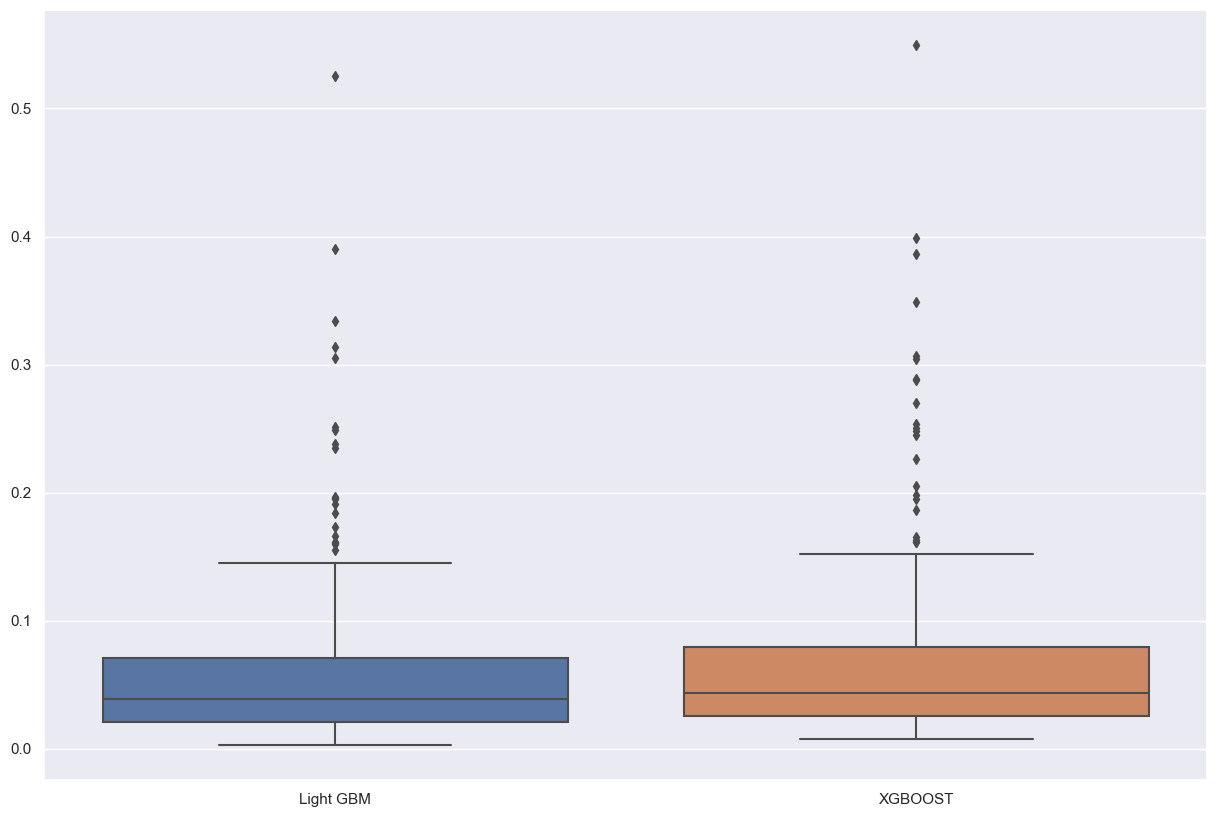

In [174]:
%%time
loss_xg = eval_xg(xgmodel)
loss_lgbm = eval_lgbm(lgbm_model)

df = pd.DataFrame({
    "Light GBM": loss_lgbm,
    "XGBOOST": loss_xg
})

sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(data=df)

In [177]:
print(f"Light GBM: {df['Light GBM'].mean()}")
print(f"XGBoost: {df['XGBOOST'].mean()}")

Light GBM: 0.058569123700335755
XGBoost: 0.06633451338351602


Text(0.5, 1.0, 'XGBoost')

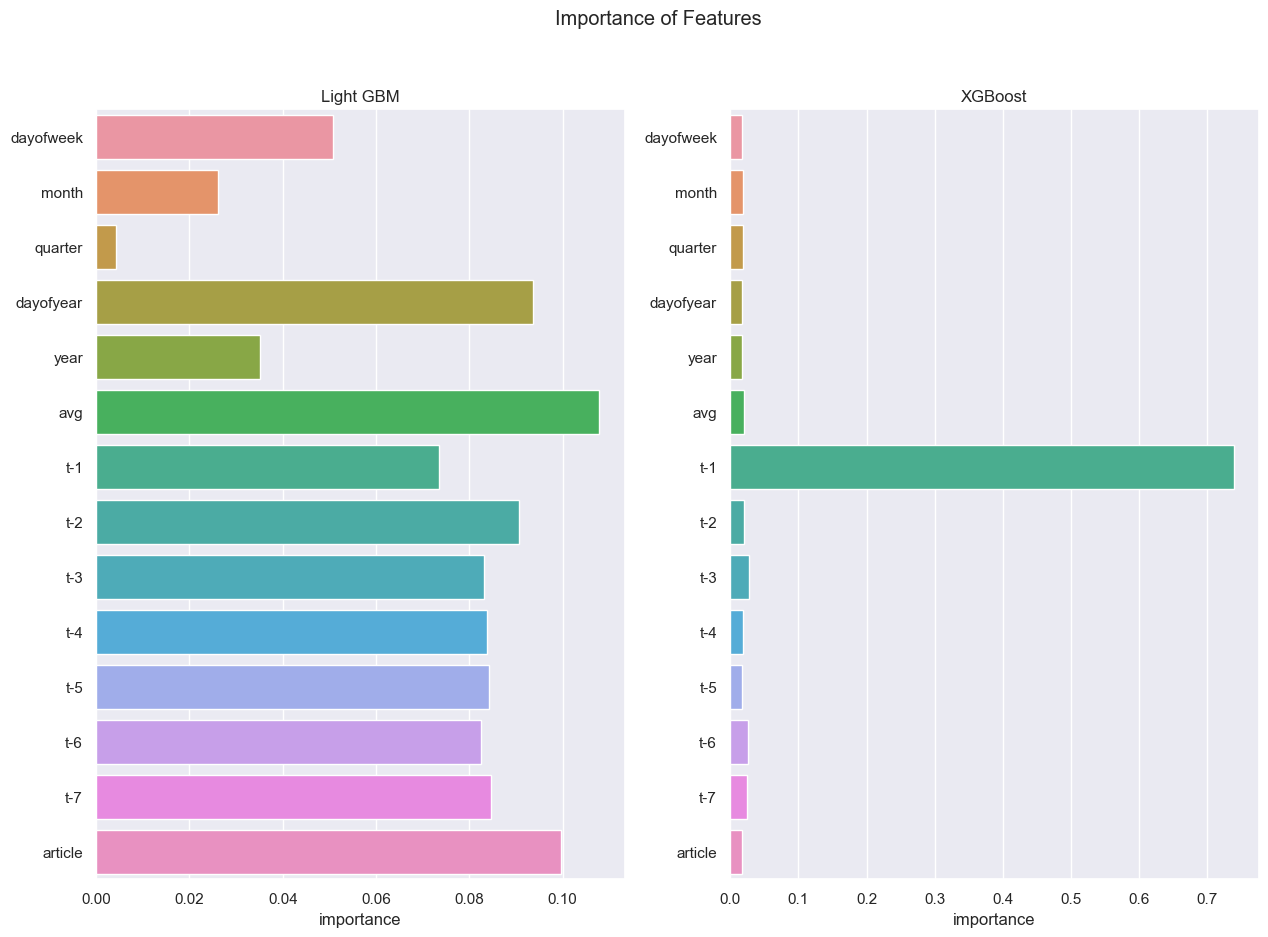

In [178]:
df_lgbm = pd.DataFrame(data=lgbm_model.feature_importances_,
                  index=lgbm_model.feature_name_,
                  columns=["importance"])

df_xg = pd.DataFrame(data=xgmodel.feature_importances_,
                  index=xgmodel.feature_names_in_,
                  columns=["importance"])

x = sum(df_lgbm["importance"])
df_lgbm /= x

fig, axes = plt.subplots(1, 2)
fig.suptitle("Importance of Features")

sns.barplot(ax=axes[0], x=df_lgbm["importance"], y=df_lgbm.index)
axes[0].set_title("Light GBM")

sns.barplot(ax=axes[1], x=df_xg["importance"], y=df_xg.index)
axes[1].set_title("XGBoost")

In [23]:
print(f"Music: {len(get_fileNames('Music', DATA_PATH))}")
print(f"Movies: {len(get_fileNames('Movies', DATA_PATH))}")
print(f"Games: {len(get_fileNames('Games', DATA_PATH))}")
print(f"Literary: {len(get_fileNames('Literary', DATA_PATH))}")

Music: 198
Movies: 101
Games: 175
Literary: 176


,views,dayofweek,month,quarter,dayofyear,year,avg
timestamp,,,,,,,
2015-07-01,1.141852,2,7,3,182,2015,1.278017
2015-07-02,1.134223,3,7,3,183,2015,1.278017
2015-07-03,1.127786,4,7,3,184,2015,1.278017
2015-07-04,1.057933,5,7,3,185,2015,1.278017
2015-07-05,1.105614,6,7,3,186,2015,1.278017
...,...,...,...,...,...,...,...
2022-11-27,1.184051,6,11,4,331,2022,1.278017
2022-11-28,1.228871,0,11,4,332,2022,1.278017
2022-11-29,1.231970,1,11,4,333,2022,1.278017


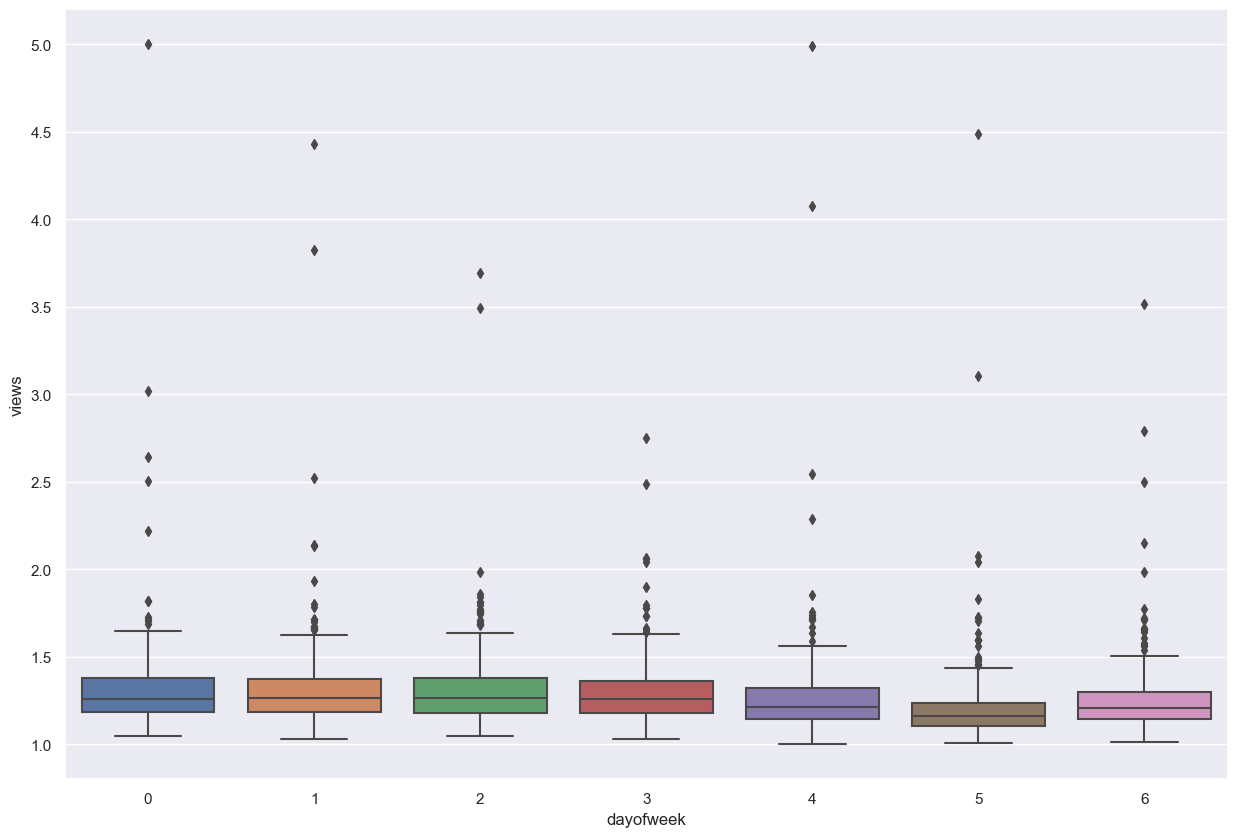

In [19]:
dfs = []
for category in ["Music", "Games", "Movies", "Literary"]:
    for file in get_fileNames(category):
        data, _ = make_data(category, file, 14)
        dfs.append(data)
df = pd.concat(dfs)

sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(data=df, x="dayofweek", y="views")
df